# Linear regression

In [2]:
import torch
import matplotlib.pyplot as plt

## Analytic solution

$ W = (X^T X)^{-1} X^T y$

tensor([0.8421, 1.0783])

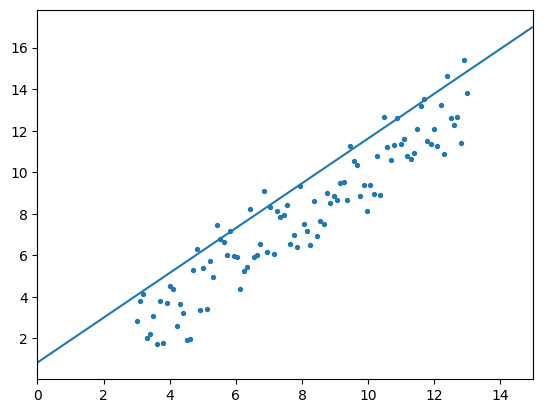

In [3]:
x = torch.cat([torch.ones((100,))[..., None] * 3, torch.linspace(0, 10, 100)[..., None]], dim=1)
y = x.sum(dim=1) + torch.randn((100))

plt.scatter(x.sum(dim=1), y, s=8)
plt.xlim(0, 15)

w = torch.linalg.pinv(x.T @ x) @ x.T @ y
plt.plot([0, 15], [w[0], w[0] + 15 * w[1]])
w

## Gradient descent solution

In [4]:
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

In [5]:
EPOCHS = 10
ETA = 0.01

for e in range(EPOCHS):

    loss = torch.sum(((w * x.sum(dim=1) + b) - y)**2) / y.shape[0]

    print(f"EPOCH: {e}, loss: {loss:.4f}")

    with torch.no_grad():
        loss.backward()

        w -= ETA * w.grad
        b -= ETA * b.grad

        w.grad = None
        b.grad = None


EPOCH: 0, loss: 32.2839
EPOCH: 1, loss: 8.0338
EPOCH: 2, loss: 2.7289
EPOCH: 3, loss: 1.5684
EPOCH: 4, loss: 1.3146
EPOCH: 5, loss: 1.2590
EPOCH: 6, loss: 1.2469
EPOCH: 7, loss: 1.2442
EPOCH: 8, loss: 1.2436
EPOCH: 9, loss: 1.2435


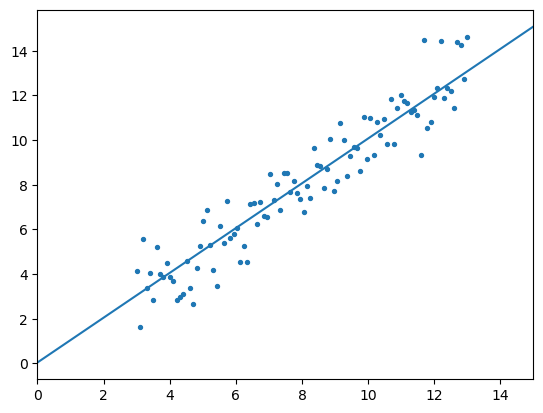

In [12]:
plt.scatter(x.sum(dim=1), y, s=8)
plt.xlim(0, 15)

b_np = b.detach().numpy()
w_np = w.detach().numpy()

plt.plot([0, 15], [b_np, b_np + 15 * w_np])

## Multivariate Linear regression and L2 regularization

In [13]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

dataset = load_diabetes()

X = torch.tensor(dataset.data)
y = torch.tensor(dataset.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([353, 10]),
 torch.Size([89, 10]),
 torch.Size([353]),
 torch.Size([89]))

In [14]:
from torch.utils.data import DataLoader
from torch.optim import SGD

class RidgeRegression:
    def __init__(self, alpha=0.1, batch_size=32, epochs=10, eta=0.01, use_torch_sgd=False) -> None:
        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.eta = eta
        self.w = None
        self.b = None
        self.losses = None
        self.use_torch_sgd = use_torch_sgd
    
    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.losses = []
        self.w = torch.normal(0.0, 1.0, size=[X.shape[1]], dtype=torch.float64, requires_grad=True)
        self.b = torch.normal(0.0, 1.0, size=[1], dtype=torch.float64, requires_grad=True)

        optim = SGD([self.w, self.b], self.eta, weight_decay=self.alpha) \
            if self.use_torch_sgd else None

        training_set = torch.cat([X, y.reshape(-1, 1)], dim=1)
        train_dataloader = DataLoader(training_set, self.batch_size, shuffle=True)

        for _ in range(self.epochs):
            
            batch_loss = []
            for batch in train_dataloader:
                train_X = batch[:, :-1]
                train_y = batch[:, -1]

                y_hat = torch.matmul(train_X, self.w) + self.b

                loss = torch.sum((train_y - y_hat)**2) / train_y.shape[0] + self.alpha/2 * torch.matmul(self.w, self.w)

                batch_loss.append(loss.item())

                with torch.no_grad():
                    loss.backward()
                    
                    if self.use_torch_sgd:
                        optim.step()
                        optim.zero_grad()
                    else:
                        self.w -= self.eta * self.w.grad
                        self.b -= self.eta * self.b.grad
                        
                        self.w.grad = None
                        self.b.grad = None

            self.losses.append(sum(batch_loss) / len(batch_loss))

        return self
    
    def predict(self, X: torch.Tensor):
        return torch.matmul(X, self.w) + self.b

5494.803566585924

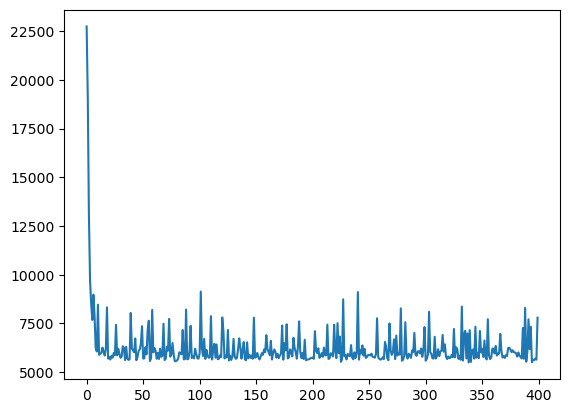

In [15]:
rlr = RidgeRegression(epochs=400, alpha=0.3, use_torch_sgd=True).fit(X_train, y_train)

plt.plot(rlr.losses)
min(rlr.losses)

# Softmax regression

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.nn.functional import one_hot

dataset = load_iris()

X = torch.tensor(dataset.data)
y = one_hot(torch.tensor(dataset.target).long(), num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Softmax regression from scratch

In [19]:
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.nn.functional import cross_entropy, softmax

class SoftmaxRegressionScratch:
    def __init__(self, batch_size=16, eta=0.01, epochs=10) -> None:
        self.batch_size = batch_size
        self.eta = eta
        self.params = dict()
        self.losses = None
        self.epochs = epochs
    
    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.params['W'] = torch.normal(0, 0.1, size=[X.shape[1], y.shape[1]], dtype=torch.float64, requires_grad=True)
        self.params['b'] = torch.normal(0, 0.1, size=[y.shape[1]], dtype=torch.float64, requires_grad=True)
        self.losses = []
        
        optimizer = SGD(self.params.values(), self.eta)

        training_set = torch.cat([X, y], dim=1)
        train_dataloader = DataLoader(training_set, self.batch_size, shuffle=True)

        for _ in range(self.epochs):
            batch_loss = []
            for batch in train_dataloader:
                batch_X = batch[:, :-y.shape[1]]
                batch_y = batch[:, -y.shape[1]:]
                
                optimizer.zero_grad()
                y_pred = self.predict(batch_X)
                loss = cross_entropy(y_pred, batch_y)

                batch_loss.append(loss.item())
                
                with torch.no_grad():
                    loss.backward()
                    optimizer.step()

            self.losses.append(sum(batch_loss) / len(batch_loss))
        
        return self
    
    def predict(self, X: torch.Tensor):
        exp_o = torch.exp(torch.matmul(X, self.params['W']) + self.params['b'])
        y_hat = exp_o / exp_o.sum(1, keepdim=True)
        return y_hat
        # return softmax(torch.matmul(X, self.params['W']) + self.params['b'], dim=1)
    
    def score(self, X: torch.Tensor, y: torch.Tensor):
        return torch.sum(self.predict(X).argmax(dim=1) == y.argmax(dim=1)) / y.shape[0]
    

tensor(1.)

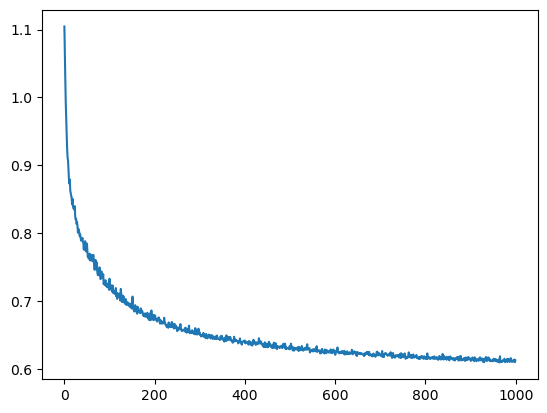

In [20]:
sr = SoftmaxRegressionScratch(epochs=1000, eta=0.1, batch_size=32).fit(X_train, y_train)

plt.plot(sr.losses)
sr.score(X_test, y_test)

## Softmax regression with pytorch primitives

In [21]:
from torch.nn.functional import cross_entropy, softmax
from torch.nn import Sequential, LazyLinear, Softmax, Module

class SoftmaxRegression(Module):
    def __init__(self, batch_size=16, eta=0.01, epochs=10, num_outputs=3) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.eta = eta
        self.net = Sequential(
            LazyLinear(num_outputs),
            Softmax(dim=1)
        )
        self.losses = None
        self.epochs = epochs
    
    def forward(self, X):
        return self.net(X)
    
    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.losses = []
        optimizer = SGD(self.net.parameters(), self.eta)

        training_set = torch.cat([X, y], dim=1).type(torch.float32)
        train_dataloader = DataLoader(training_set, self.batch_size, shuffle=True)

        for _ in range(self.epochs):
            batch_loss = []
            for batch in train_dataloader:
                batch_X = batch[:, :-y.shape[1]]
                batch_y = batch[:, -y.shape[1]:]
                
                optimizer.zero_grad()
                y_pred = self.forward(batch_X)
                loss = cross_entropy(y_pred, batch_y)

                batch_loss.append(loss.item())
                
                with torch.no_grad():
                    loss.backward()
                    optimizer.step()

            self.losses.append(sum(batch_loss) / len(batch_loss))
        
        return self
    
    # def predict(self, X: torch.Tensor):
    #     return softmax(torch.matmul(X, self.params['W']) + self.params['b'], dim=1)
    
    def score(self, X: torch.Tensor, y: torch.Tensor):
        return torch.sum(self.forward(X.type(torch.float32)).argmax(dim=1) == y.argmax(dim=1)) / y.shape[0]

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(0.6667)

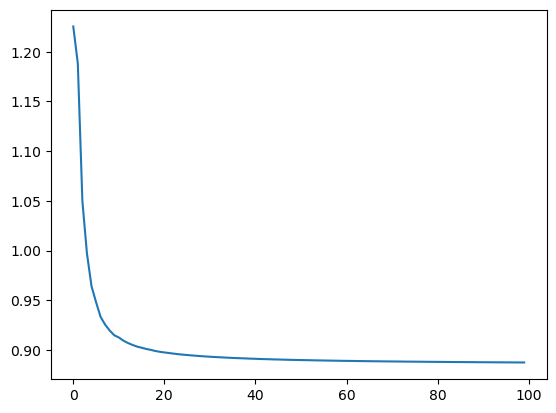

In [22]:
sr = SoftmaxRegression(epochs=100, eta=0.1, batch_size=8, num_outputs=3).fit(X_train, y_train)

plt.plot(sr.losses)
sr.score(X_test, y_test)